<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Получение-данных-свечей" data-toc-modified-id="Получение-данных-свечей-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Получение данных свечей</a></span></li><li><span><a href="#Добавление-индикаторов" data-toc-modified-id="Добавление-индикаторов-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Добавление индикаторов</a></span><ul class="toc-item"><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Пересечение-скользящих-средних" data-toc-modified-id="Пересечение-скользящих-средних-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Пересечение скользящих средних</a></span></li><li><span><a href="#Ресэмплирование" data-toc-modified-id="Ресэмплирование-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Ресэмплирование</a></span></li></ul></li><li><span><a href="#Мой-портфель" data-toc-modified-id="Мой-портфель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Мой портфель</a></span></li><li><span><a href="#Тестирование-на-исторических-данных" data-toc-modified-id="Тестирование-на-исторических-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование на исторических данных</a></span><ul class="toc-item"><li><span><a href="#Визуализация" data-toc-modified-id="Визуализация-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Визуализация</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import open_finam_data
from datetime import datetime
import numpy as np

In [2]:
# НАстройка отображения графиков
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 12)

## Получение данных свечей

In [3]:
tolls_path_list = ['HYDR_190101_200425.csv','POLY_190101_200425.csv','YNDX_190101_200425.csv']
df_dikt = {}
for toll_path in tolls_path_list:
    df = open_finam_data.open('../../input/' + toll_path)
    #  Фильтр дат
#     df = df.loc[df.index >= '2020-03-10']
    df_dikt[toll_path.split('_')[0]] = df

## Добавление индикаторов

### Скользящее среднее

In [4]:
for df_toll in list(df_dikt):
    df_dikt[df_toll]['ma_samp_slow'] = df_dikt[df_toll].CLOSE.rolling(window = 350, min_periods = 350).mean()
    df_dikt[df_toll]['ma_samp_fast'] = df_dikt[df_toll].CLOSE.rolling(window = 100, min_periods = 100).mean()
#     print (str(df_toll) + '\n' + str(df_dikt[df_toll].dtypes) + '\n')

### Пересечение скользящих средних

In [5]:
i = 2
for df_toll in list(df_dikt):
    ma_difference = []
    for index in range(len(df_dikt[df_toll].index)):
        ma_difference.append(df_dikt[df_toll].loc[df_dikt[df_toll].index[index], 'ma_samp_slow'] - df_dikt[df_toll].loc[df_dikt[df_toll].index[index], 'ma_samp_fast'])
        if index < i: continue
        ma_sum = ma_difference[-1] + ma_difference[-1-i]
        peresech = abs(ma_sum) < abs(ma_difference[-1]) and abs(ma_sum) < abs(ma_difference[-1-i])
    #     if peresech == True: print(df_test.index[index])
        df_dikt[df_toll].loc[df_dikt[df_toll].index[index], 'SIGNAL'] = peresech
        df_dikt[df_toll].loc[df_dikt[df_toll].index[index], 'POZISION'] = 'short' if ma_difference[-1] > 0 else 'long'
# Вывести таблицу с маркерами 
#     df_dikt[df_toll][df_dikt[df_toll].SIGNAL == True].head()

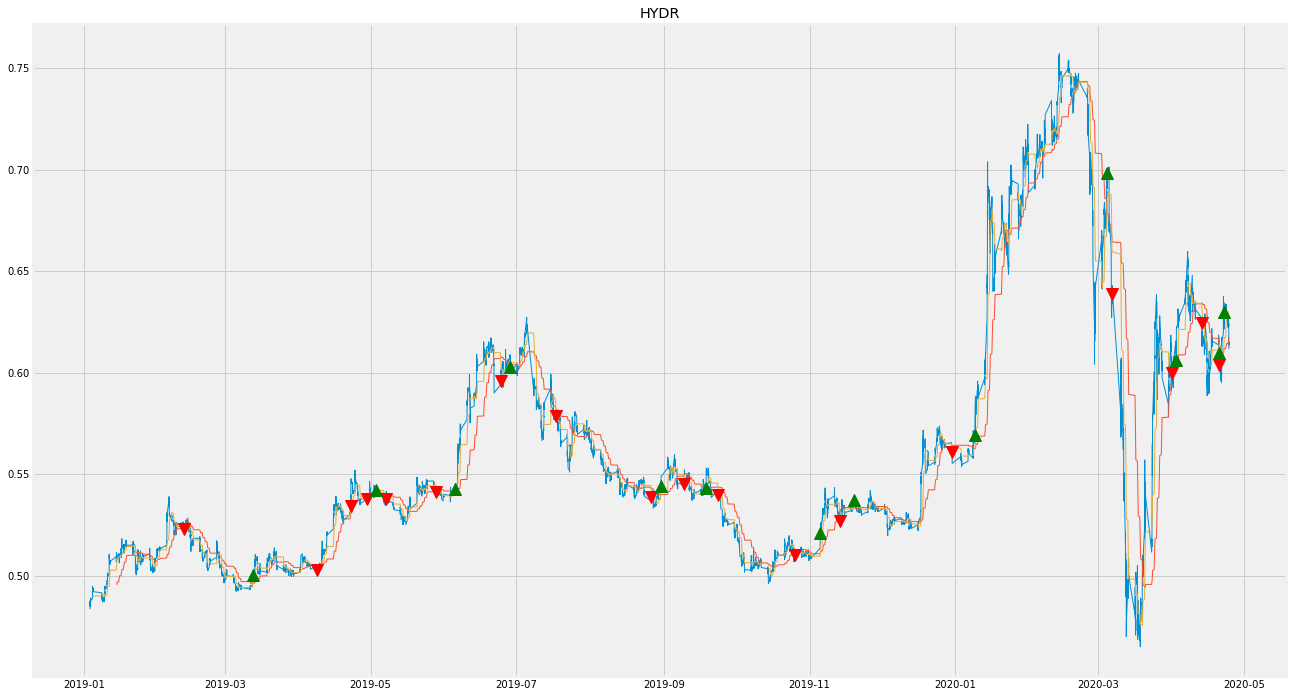

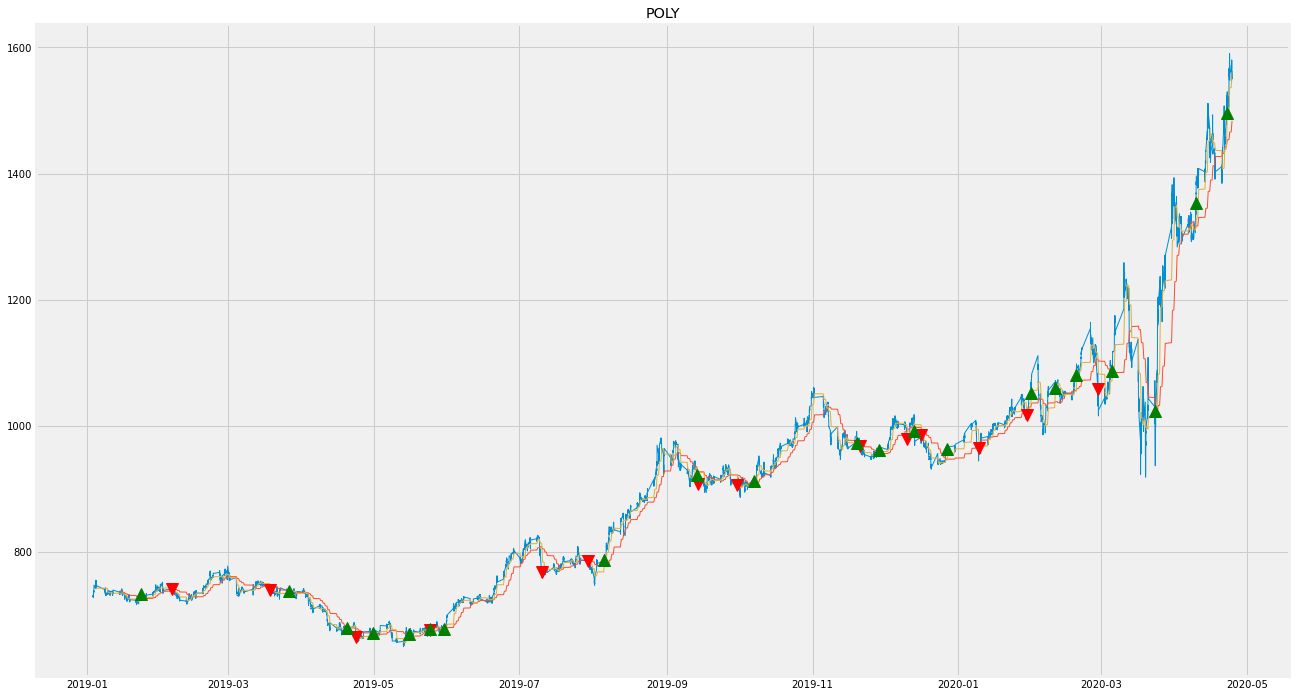

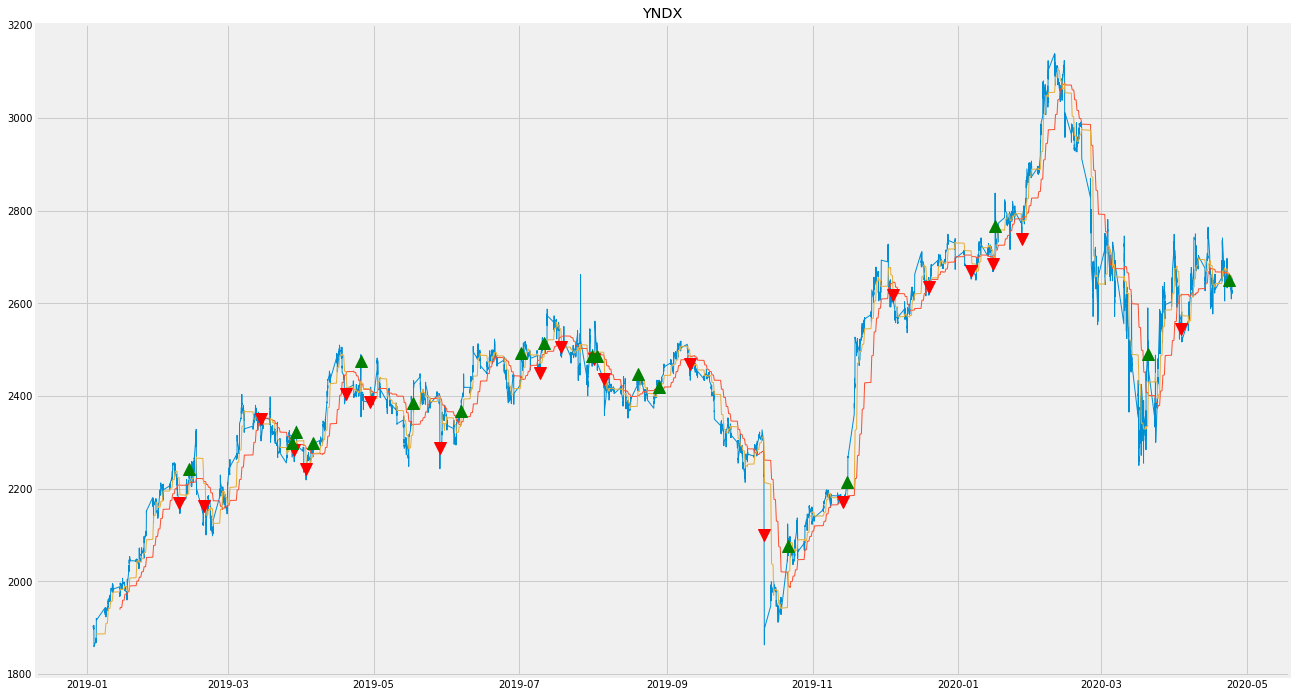

In [27]:
# Вывести график
for df_toll in list(df_dikt):
    fig, ax = plt.subplots()
    ax.set_title(df_toll)
    ax.plot(df_dikt[df_toll].CLOSE.dropna(),linewidth=1)
    ax.plot(df_dikt[df_toll].ma_samp_slow.dropna(),linewidth=1)
    ax.plot(df_dikt[df_toll].ma_samp_fast.dropna(),linewidth=1)
    ax.plot(df_dikt[df_toll][(df_dikt[df_toll].POZISION == 'short')&(df_dikt[df_toll].SIGNAL == True)].CLOSE, 'rv', markersize=12)
    ax.plot(df_dikt[df_toll][(df_dikt[df_toll].POZISION == 'long')&(df_dikt[df_toll].SIGNAL == True)].CLOSE, 'g^', markersize=12)
    plt.show()

# Определяем период который перекрывают все инструменты

In [7]:
data_period_dick = {'stert':[], 'end':[], 'step' : []}
for tool in list(df_dikt):
    data_period_dick['stert'].append(df_dikt[tool].index[0])
    data_period_dick['end'].append(df_dikt[tool].index[-1])
    data_period_dick['step'].append(df_dikt[tool].index[1] - df_dikt[tool].index[0])
data_period_dick['stert'] = max(data_period_dick['stert'])
data_period_dick['end'] = min(data_period_dick['end'])
data_period_dick['step'] = data_period_dick['step'][0]
data_period_dick

{'stert': Timestamp('2019-01-03 10:10:00'),
 'end': Timestamp('2020-04-24 18:50:00'),
 'step': Timedelta('0 days 00:10:00')}

In [8]:
# Словарь с котировами по цене закрытия на инструменты нахдящиеся в работе
cot_dict = {}
for tool in list(df_dikt):
    cot_dict[tool] = 0
cot_dict

{'HYDR': 0, 'POLY': 0, 'YNDX': 0}

In [9]:
lot_size_dict = {'HYDR': 1000, 'POLY': 1, 'YNDX': 1}

### Ресэмплирование

In [10]:
# Превщение последовательный временной датафрейм
for tool in list(df_dikt):
    df_dikt[tool] = df_dikt[tool].resample(data_period_dick['step']).last()

In [11]:
# Создание диапазана для отдельного использования
data_time_range = pd.date_range(start = data_period_dick['stert'], end = data_period_dick['end'], freq = data_period_dick['step'])

## Мой портфель

In [12]:
# Создание данных о стоимости портфеля
portfel_df = pd.DataFrame(index=data_time_range)
portfel_df_dict = {}
# portfel_df['Portfel_vol'] = portfel_df.apply(lambda x: 0, axis = 1)

## Тестирование на исторических данных

In [13]:
portfel_df = pd.DataFrame(index=data_time_range)
portfel_df_dict = {}
for tool in list(cot_dict):
    # Создание данных о стоимости портфеля
    portfel_df_dict[tool] = portfel_df

    import financial_account
    my_account = financial_account.Financial_account()
    my_account.add_mone(100000)
    data_null = data_time_range[0]
    data_prise = data_null

    for data_time in data_time_range:
    #   Определение акруальных котировок
        cot_dict[tool] = df_dikt[tool].loc[data_time,'CLOSE']
        portfel_df.loc[data_time, 'Portfel_vol'] = my_account.get_portfel_price(cot_dict)
        if df_dikt[tool].loc[data_time, 'SIGNAL'] != True: continue
        if df_dikt[tool].loc[data_time, 'POZISION'] == 'long':
            my_account.buy_lot(lot_name = tool,lot_count = 10, lot_size = lot_size_dict[tool], lot_price = cot_dict[tool])
            portfel_df.loc[data_time, 'trade'] = 'buy'
        if df_dikt[tool].loc[data_time, 'POZISION'] == 'short':
            if tool not in list(my_account.tool_dict): continue
            my_account.sell_lot(lot_name = tool,lot_count = my_account.tool_dict[tool], lot_size = 1, lot_price = cot_dict[tool])
            portfel_df.loc[data_time, 'trade'] = 'sell'
        portfel_df_dict[tool].loc[data_time, 'Portfel_vol'] = my_account.get_portfel_price(cot_dict)   
    print('Инструмент: ' + tool + ' Состояние на конец периода: ' +  str(portfel_df_dict[tool].loc[data_period_dick['end'],'Portfel_vol']))


Инструмент: HYDR Состояние на конец периода: 100569.25025
Инструмент: POLY Состояние на конец периода: 115448.59975000002
Инструмент: YNDX Состояние на конец периода: 102890.57170000003


### Визуализация

In [14]:
# portfel_df[(portfel_df.trade == 'buy')|(portfel_df.trade == 'sell')].head()

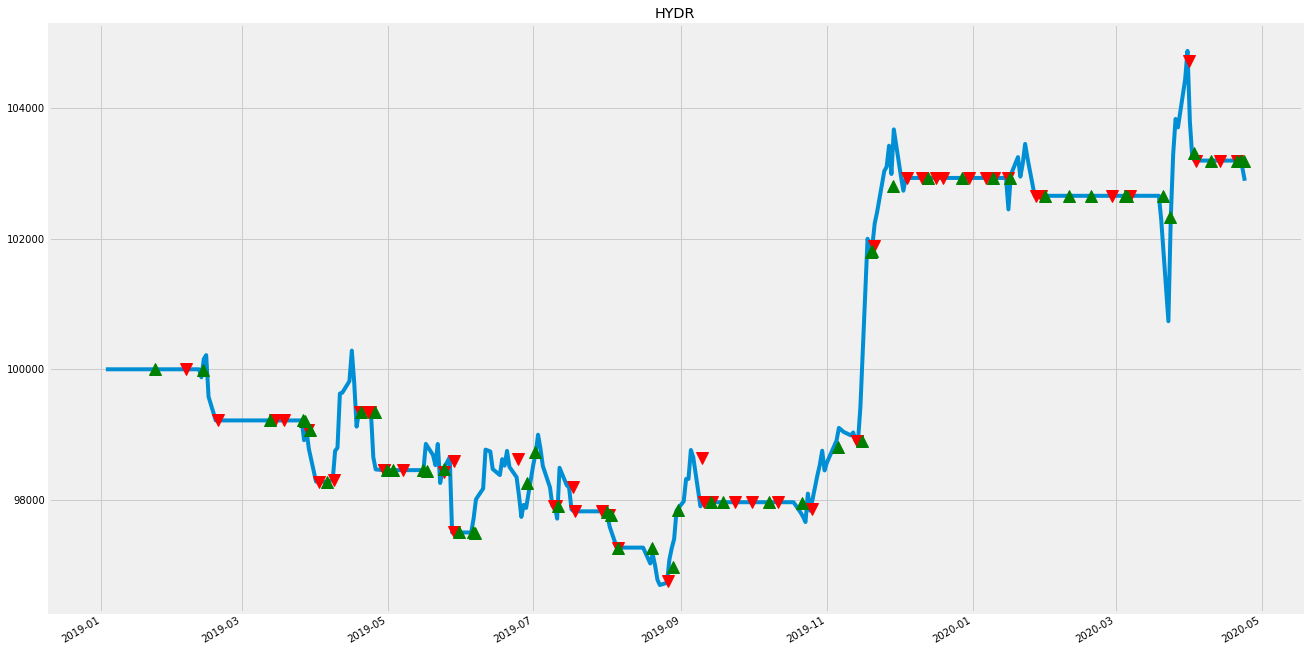

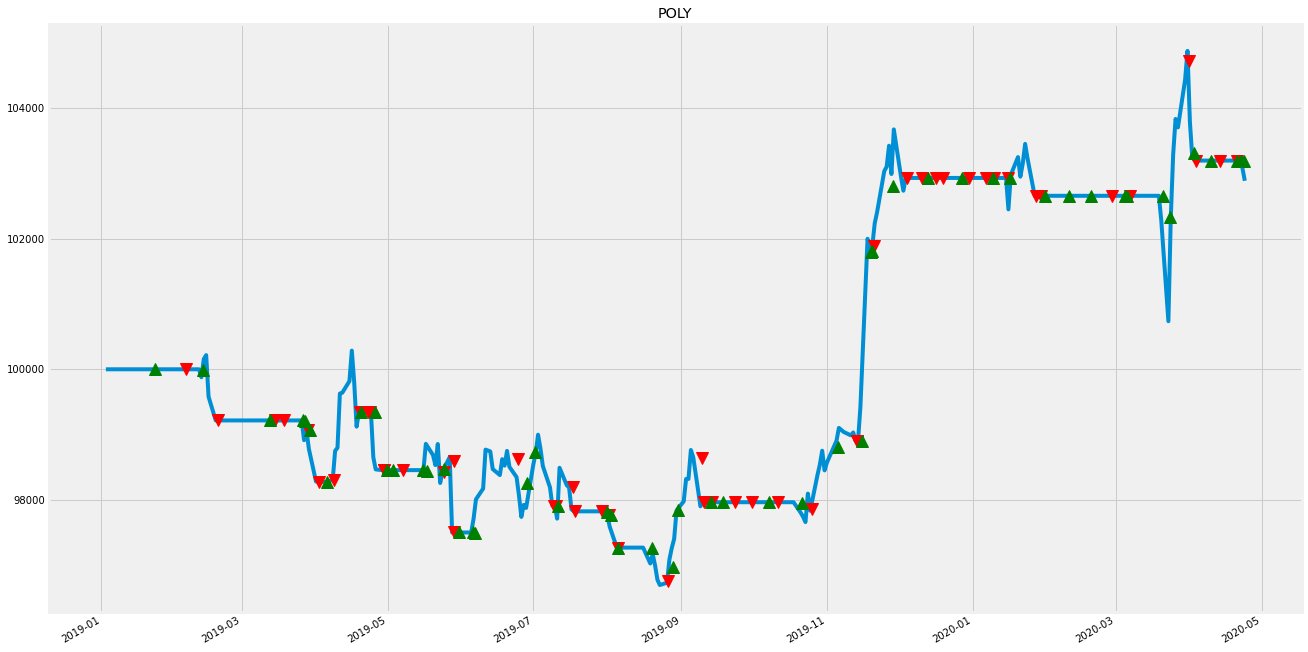

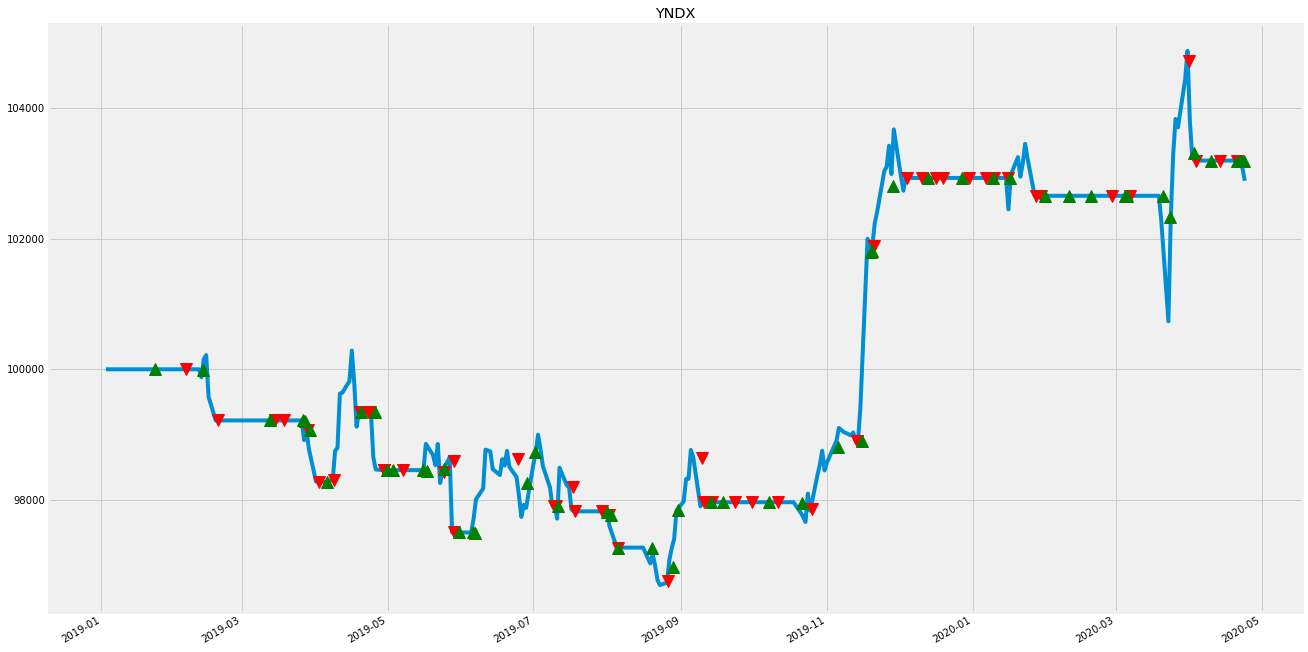

In [28]:
for tool in list(df_dikt):
    plt.title(tool)
    portfel_df_dict[tool].Portfel_vol.resample('D').last().dropna().plot()
    plt.plot(portfel_df_dict[tool][portfel_df_dict[tool].trade == 'sell'].Portfel_vol, 'rv', markersize=12)
    plt.plot(portfel_df_dict[tool][portfel_df_dict[tool].trade == 'buy'].Portfel_vol, 'g^', markersize=12)
    # plt.axis([0, 6, 0, 20])
    plt.show()